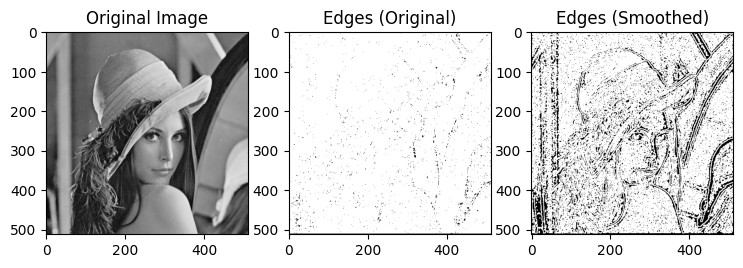

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import io
from PIL import Image

# Gaussian function
def gauss(sz, s):
    ctr = sz // 2
    kernel = np.zeros((sz, sz))
    for i in range(sz):
        for j in range(sz):
            x = i - ctr
            y = j - ctr
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * s**2)) / (2 * np.pi * s**2)
    return kernel / np.sum(kernel)

# Convolution function
def apply_conv(img, k, norm=True):
    ir, ic = img.shape
    kr, kc = k.shape
    pad = (kr - 1) // 2
    padded_img = np.pad(img, pad_width=pad, mode='constant', constant_values=0)
    res = np.zeros((ir, ic))

    for i in range(ir):
        for j in range(ic):
            res[i, j] = np.sum(padded_img[i:i + kr, j:j + kc] * k)

    if norm:
        min_val = np.min(res)
        max_val = np.max(res)
        res = (res - min_val) / (max_val - min_val) * 255

    return res

# Zero-crossing detection for edges
def detect_edges(img):
    ir, ic = img.shape
    res = np.zeros((ir, ic))

    for i in range(1, ir - 1):
        for j in range(1, ic - 1):
            region = img[i-1:i+2, j-1:j+2]
            if np.max(region) > 0 and np.min(region) < 0:
                res[i, j] = 255
    return res

# Laplacian filter (3x3 kernel)
def lap_filt(img):
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    return apply_conv(img, kernel, norm=False)

# Apply Laplacian of Gaussian (LoG)
def log_filter(img, sz=5, s=1):
    # 1. Apply Gaussian smoothing
    g_kernel = gauss(sz, s)
    smoothed_img = apply_conv(img, g_kernel, norm=False)

    # 2. Apply Laplacian
    lap_img = lap_filt(smoothed_img)

    # 3. Detect edges
    edges = detect_edges(lap_img)

    return smoothed_img, lap_img, edges

# Apply Laplacian directly to original image
def lap_on_orig(img):
    lap_img = lap_filt(img)
    edges = detect_edges(lap_img)
    return lap_img, edges

# Load image from URL
def get_image(url):
    with urllib.request.urlopen(url) as res:
        img_data = res.read()
    img = Image.open(io.BytesIO(img_data)).convert('L')  # Convert to grayscale
    return np.array(img)

# Display images
def show_images(orig_img, lap_orig, edges_orig, smoothed_edges):
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(orig_img, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('Edges (Original)')
    plt.imshow(edges_orig, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Edges (Smoothed)')
    plt.imshow(smoothed_edges, cmap='gray')

    plt.show()

# Main function
def main():
    # Load the image from the URL
    img_url = "https://github.com/saptarshihalder/Assignment/blob/main/lena_color_512.jpg?raw=true"
    img = get_image(img_url)

    # 1. Laplacian of Gaussian (LoG)
    _, _, smoothed_edges = log_filter(img, sz=5, s=1)

    # 2. Laplacian on original image
    _, edges_orig = lap_on_orig(img)

    # 3. Display the results
    show_images(img, _, edges_orig, smoothed_edges)

if __name__ == "__main__":
    main()
